# DBSCAN Clustering 

We'll Implement the DBSCAN algorithm to Pokemon Lgendary Dataset.

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

## Importing the dataset

We'll Import the Pokemon Legendary Dataset and visualize some parameters of it.

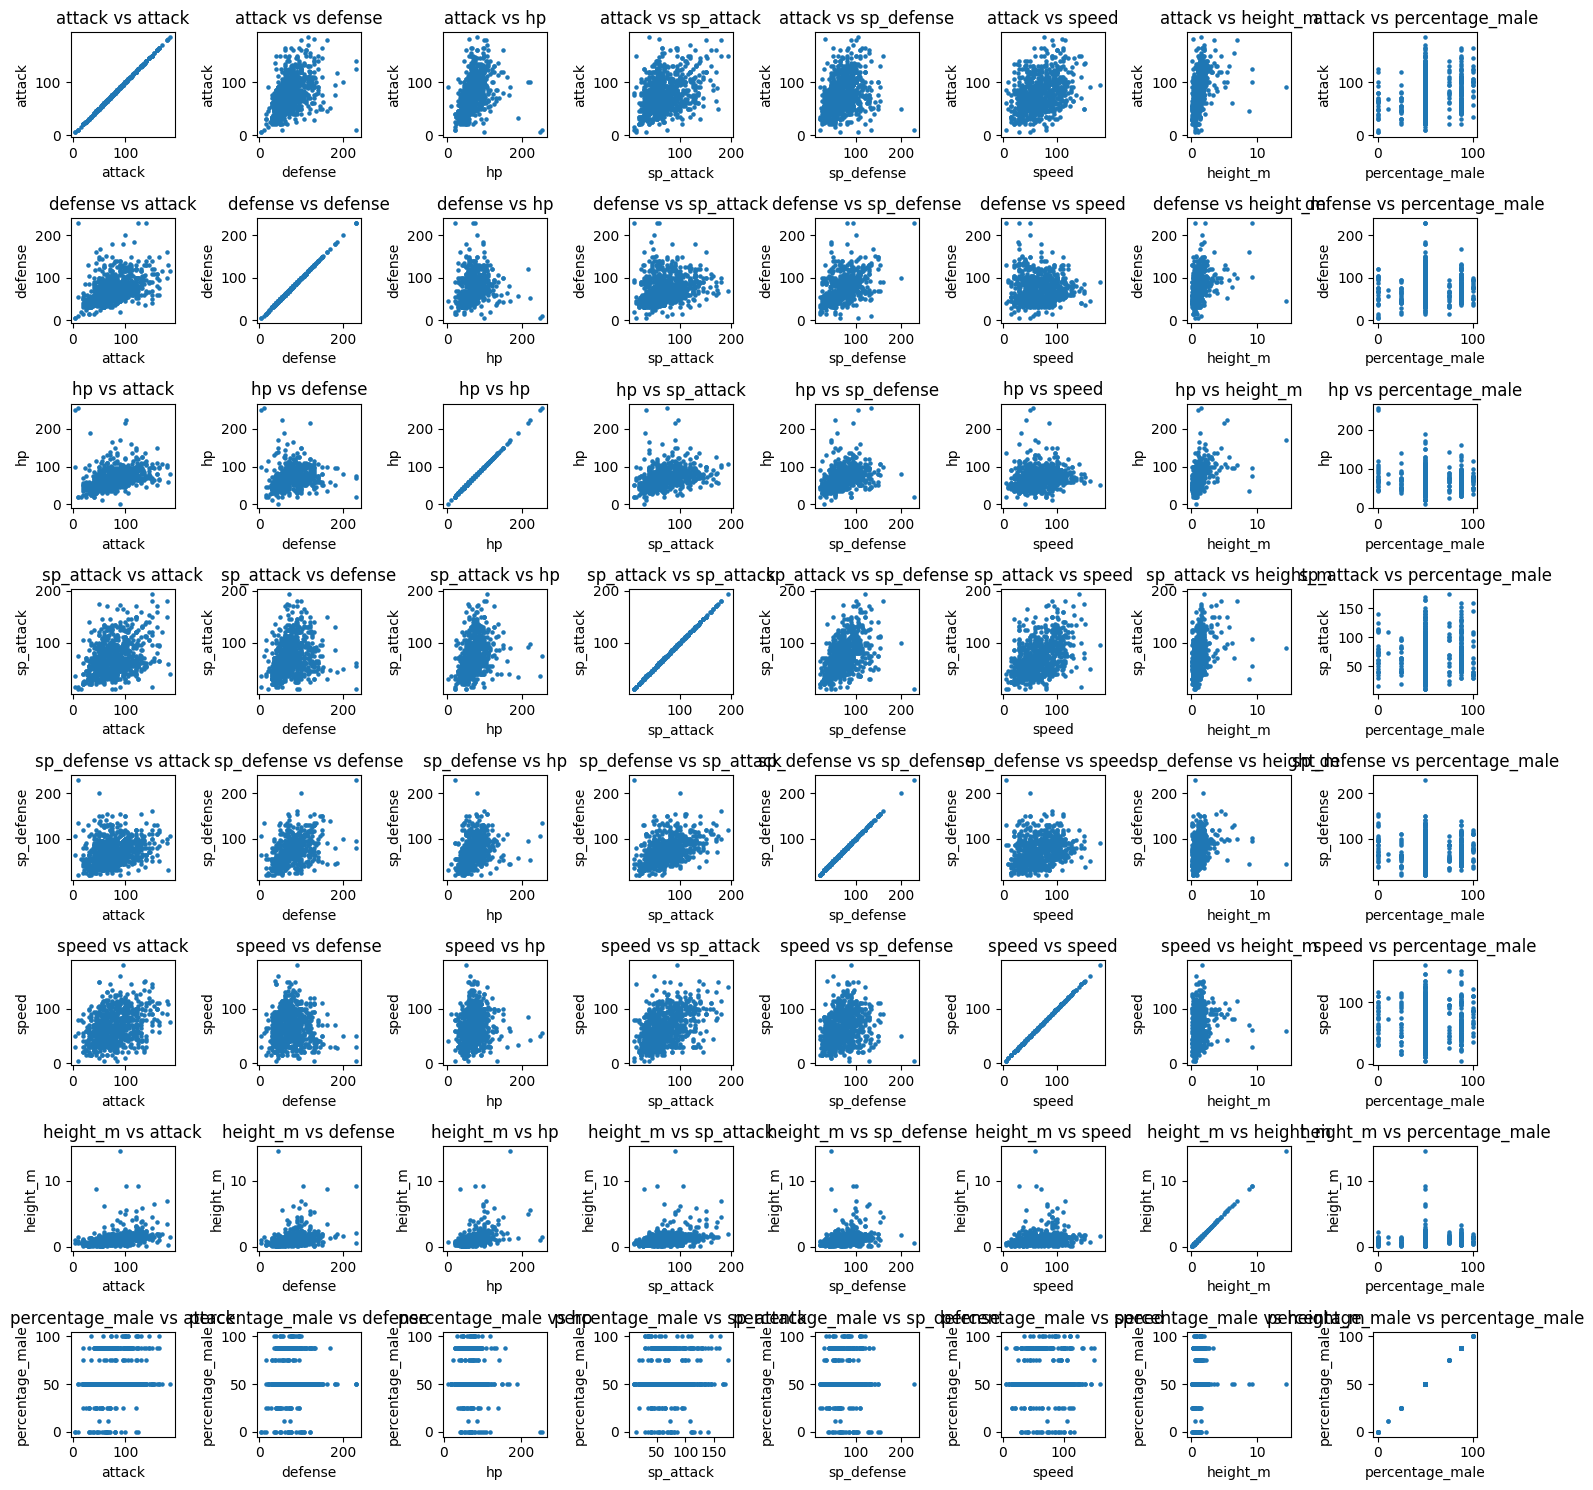

In [45]:
data = pd.read_csv('pokedex.csv')

numerical_cols = ['attack', 'defense', 'hp', 'sp_attack', 'sp_defense', 'speed', 'height_m', 'percentage_male']
n = len(numerical_cols)

fig, axes = plt.subplots(n, n, figsize=(15, 15))

for i in range(n):
    for j in range(n):
        ax = axes[i, j]

        x_col = numerical_cols[j]
        y_col = numerical_cols[i]

        ax.scatter(data[x_col], data[y_col], s=5)

        ax.set_xlabel(x_col)
        ax.set_ylabel(y_col)
        ax.set_title(f"{y_col} vs {x_col}")

plt.tight_layout()
plt.show()

## Scaling the data

Since DBSCAN is distance based, we'll scale the features so that each feature is of same weightage.

In [47]:
X = data[numerical_cols].dropna().values

def z_score_normalize(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X_scaled = (X - mean) / std
    return mean, std, X_scaled

X = z_score_normalize(X)[2]

## Implementing DBSCAN Algorithm

Now we'll create the algorithm from scratch.

In [48]:
# Calculate Euclidean Distance between two points
def euclidiean_distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2)**2))

# Ger neighbours of a point
def get_neighbours(X, point_idx, eps):
    neighbours = []
    for i in range(len(X)):
        if euclidiean_distance(X[point_idx], X[i]) < eps:
            neighbours.append(i)
    
    return neighbours

# The main DBSCAN Algorithm
def dbscan(X, eps, min_samples):
    n_samples = X.shape[0]

    labels = np.full(n_samples, 0)
    cluster_id = 0

    for i in range(n_samples):
        if labels[i] != 0:
            continue

        neighbours_indices = get_neighbours(X, i, eps)

        if len(neighbours_indices) < min_samples:
            labels[i] = -1
        else:
            cluster_id += 1

            labels[i] = cluster_id

            queue = list(neighbours_indices)

            while len(queue) != 0:
                current_index = queue.pop(0)

                if labels[current_index] ==  -1:
                    labels[current_index] = cluster_id
                
                if labels[current_index] == 0:
                    labels[current_index] = cluster_id

                    new_neighbours = get_neighbours(X, current_index, eps)

                    if len(new_neighbours) >= min_samples:
                        for neighbour_index in new_neighbours:
                            if labels[neighbour_index] == 0 or labels[neighbour_index] == -1:
                                queue.append(neighbour_index)

    return labels




## Choosing right epslison and minimum samples values.

We'll choose what values of minimum samples for a cluster and radius from a point are right. We'll take help of K nearest Neighbours for this.

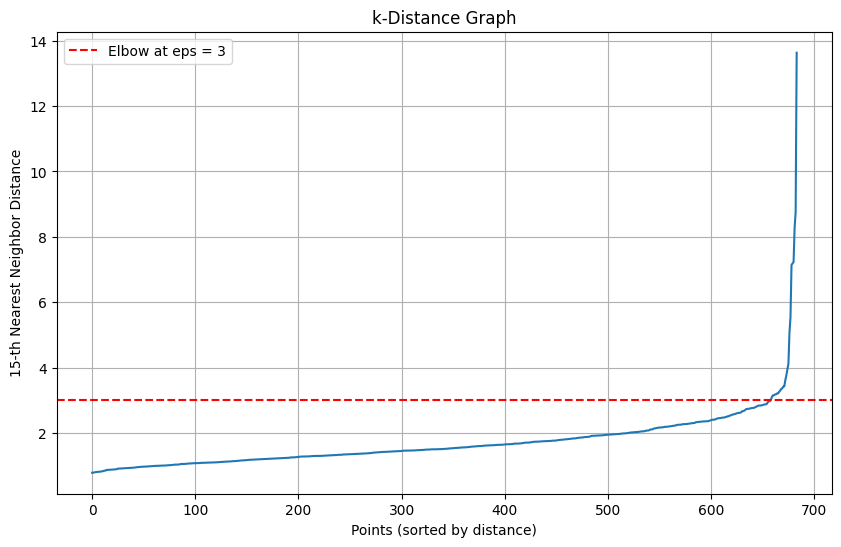

In [57]:
from sklearn.neighbors import NearestNeighbors

k = 15 # Calculate till 4th nearest neighbour.
nbrs = NearestNeighbors(n_neighbors=k+1).fit(X) 
distances, indices = nbrs.kneighbors(X) # type: ignore

k_distances = distances[:, k]
k_distances_sorted = np.sort(k_distances)

# Plot the k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(k_distances_sorted)
plt.title('k-Distance Graph')
plt.xlabel('Points (sorted by distance)')
plt.ylabel(f'{k}-th Nearest Neighbor Distance')
plt.grid(True)
plt.axhline(y=3, color='r', linestyle='--', label='Elbow at eps = 3')
plt.legend()
plt.show()


## Running DBSCAN

We'll now run our DBSCAN Algorithm.

In [58]:
epsilon = 3
min_samples = 16

labels = dbscan(X, epsilon, min_samples)

# Add to our orignal data
data_clustered = data.dropna(subset=numerical_cols).copy()
data_clustered['cluster'] = labels

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f"Estimated no. of clusters: {n_clusters}")
print(f"Estimated number of noise points: {n_noise}")

Estimated no. of clusters: 1
Estimated number of noise points: 10


### Results
 - Our algorithm only found one big cluster.
 - The noise is very less with only 10 points

## Visualising Our results

We'll now visualze the results.

C:\Users\parth\AppData\Local\Temp\ipykernel_10652\713593289.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors =cm.get_cmap('tab10', len(unique_clusters))


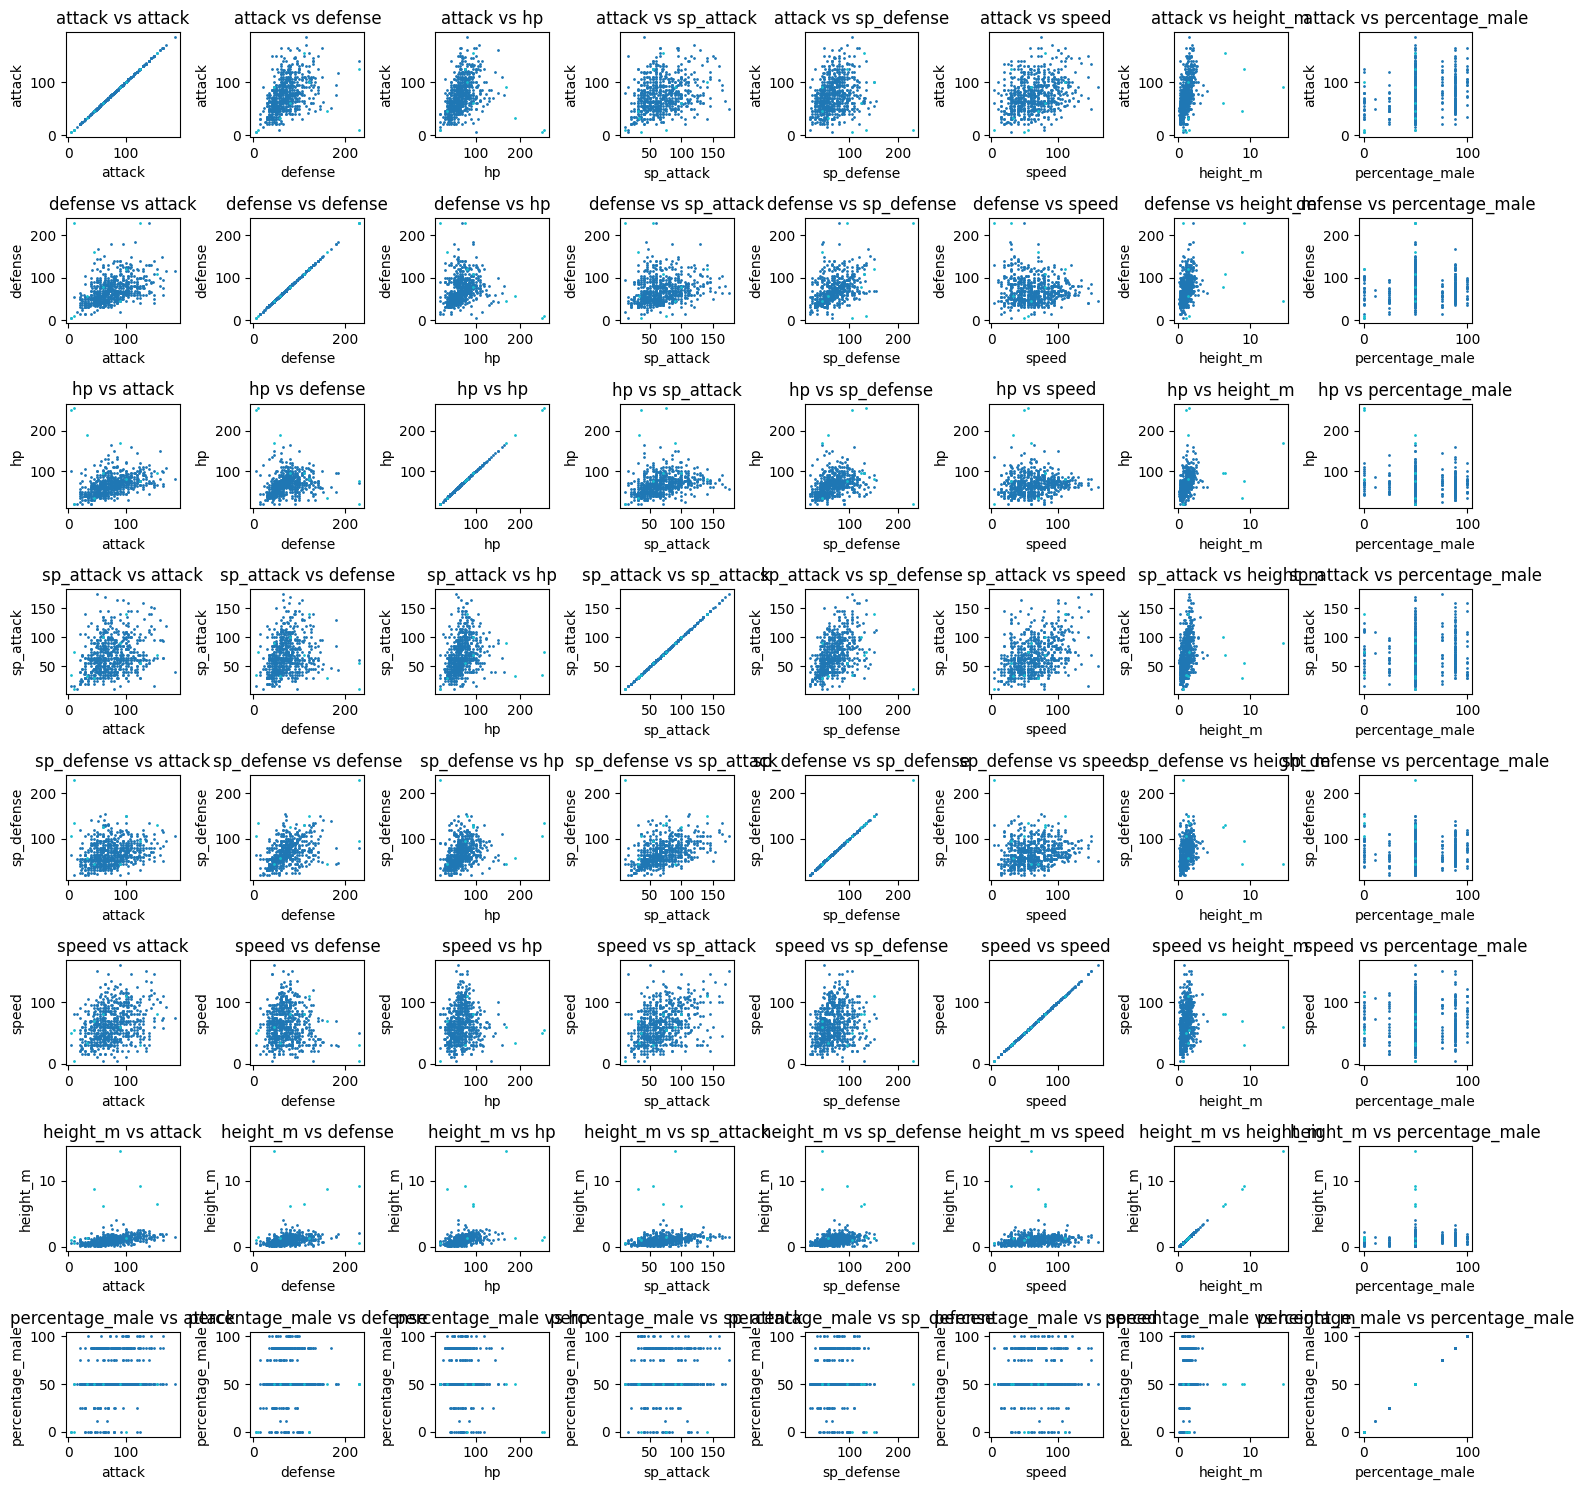

In [59]:
n = len(numerical_cols)

fig, axes = plt.subplots(n, n, figsize=(15, 15))

unique_clusters = data_clustered['cluster'].unique()

colors =cm.get_cmap('tab10', len(unique_clusters))
color_map = {cluster: colors(i) for i, cluster in enumerate(unique_clusters)}


for i in range(n):
    for j in range(n):
        ax = axes[i, j]

        x_col = numerical_cols[j]
        y_col = numerical_cols[i]

        for cluster in unique_clusters:
            subset = data_clustered[data_clustered['cluster'] == cluster]
            ax.scatter(subset[x_col], subset[y_col], 
                    s=1, 
                    color=color_map[cluster], 
                    label=cluster)

        
        ax.set_xlabel(x_col)
        ax.set_ylabel(y_col)
        ax.set_title(f"{y_col} vs {x_col}")

plt.tight_layout()
plt.show()

## Result

As we can see both visually and from our algorithm, there is only one major cluster in the provided dataset and a few noise points. This is the best fit for our data.